<a href="https://colab.research.google.com/github/holoS15/CSI_6_CSP_2122_3605631/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import packages
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
#!pip install keras
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D
from keras.preprocessing import image
%matplotlib inline
import nibabel as nib
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
from glob import glob
from skimage.io import imread
import skimage.transform as skTrans
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# Set

In [2]:
BASE_IMG_PATH=os.path.join('/content/drive/MyDrive')

In [3]:
#insert dataset
brainMRIData=pd.read_csv('/content/drive/MyDrive/Classification_clean.csv')
# find class value
brainMRIData["Class"]=brainMRIData["Diagnosis"]>0
# set datatype
brainMRIData.Class = brainMRIData.Class.astype('int')
brainMRIDataCol=brainMRIData.columns
brainMRIData

,ID_CF,FirstEpisodes_FEP__HealthyControl_HC_,Diagnosis,Gender,Age,Site 1,Site 2,Site 3,Site 4,Site 5,Site 6,Site 7,Euler,Class
0,CF_001,FEP,3,0,23.857632,0,0,0,0,0,0,0,-21,1
1,CF_002,FEP,3,0,28.952772,0,0,0,0,0,0,0,-33,1
2,CF_003,FEP,1,0,20.199863,0,0,0,0,0,0,0,-55,1
3,CF_004,FEP,1,0,28.517454,0,0,0,0,0,0,0,-26,1
4,CF_005,FEP,2,1,39.101985,0,0,0,0,0,0,0,-24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,CF_800,HC,0,1,26.000000,0,0,0,0,0,1,0,-139,0
670,CF_802,HC,0,0,26.000000,0,0,0,0,0,1,0,-103,0
671,CF_803,HC,0,1,26.000000,0,0,0,0,0,1,0,-215,0
672,CF_804,HC,0,1,30.000000,0,0,0,0,0,1,0,-81,0


In [4]:
# perform path
brainMRIImages=glob(os.path.join(BASE_IMG_PATH,'brains','wCF_*'))
print(os.path.join(BASE_IMG_PATH,'brains','wCF_*'))
print(len(brainMRIImages),' matching files found:',brainMRIImages[0])

/content/drive/MyDrive/brains/wCF_*
761  matching files found: /content/drive/MyDrive/brains/wCF_001_MRI_sMRI_CF_001_brain.nii.gz


In [5]:
brainMRIData.columns

Index(['ID_CF', 'FirstEpisodes_FEP__HealthyControl_HC_', 'Diagnosis', 'Gender',
       'Age', 'Site 1', 'Site 2', 'Site 3', 'Site 4', 'Site 5', 'Site 6',
       'Site 7', 'Euler', 'Class'],
      dtype='object')

In [6]:
# load images
imagesTest=nib.load(brainMRIImages[0])
imagesTest=imagesTest.get_fdata()
random.shuffle(imagesTest)

In [7]:
# for loop for load images
for myimages in imagesTest:
    fileName='w'+ brainMRIData['ID_CF']+'_MRI_sMRI_'+ brainMRIData['ID_CF']+'.nii.gz'  
    
    break

# print filenames
print(fileName)

0      wCF_001_MRI_sMRI_CF_001.nii.gz
1      wCF_002_MRI_sMRI_CF_002.nii.gz
2      wCF_003_MRI_sMRI_CF_003.nii.gz
3      wCF_004_MRI_sMRI_CF_004.nii.gz
4      wCF_005_MRI_sMRI_CF_005.nii.gz
                    ...              
669    wCF_800_MRI_sMRI_CF_800.nii.gz
670    wCF_802_MRI_sMRI_CF_802.nii.gz
671    wCF_803_MRI_sMRI_CF_803.nii.gz
672    wCF_804_MRI_sMRI_CF_804.nii.gz
673    wCF_805_MRI_sMRI_CF_805.nii.gz
Name: ID_CF, Length: 674, dtype: object


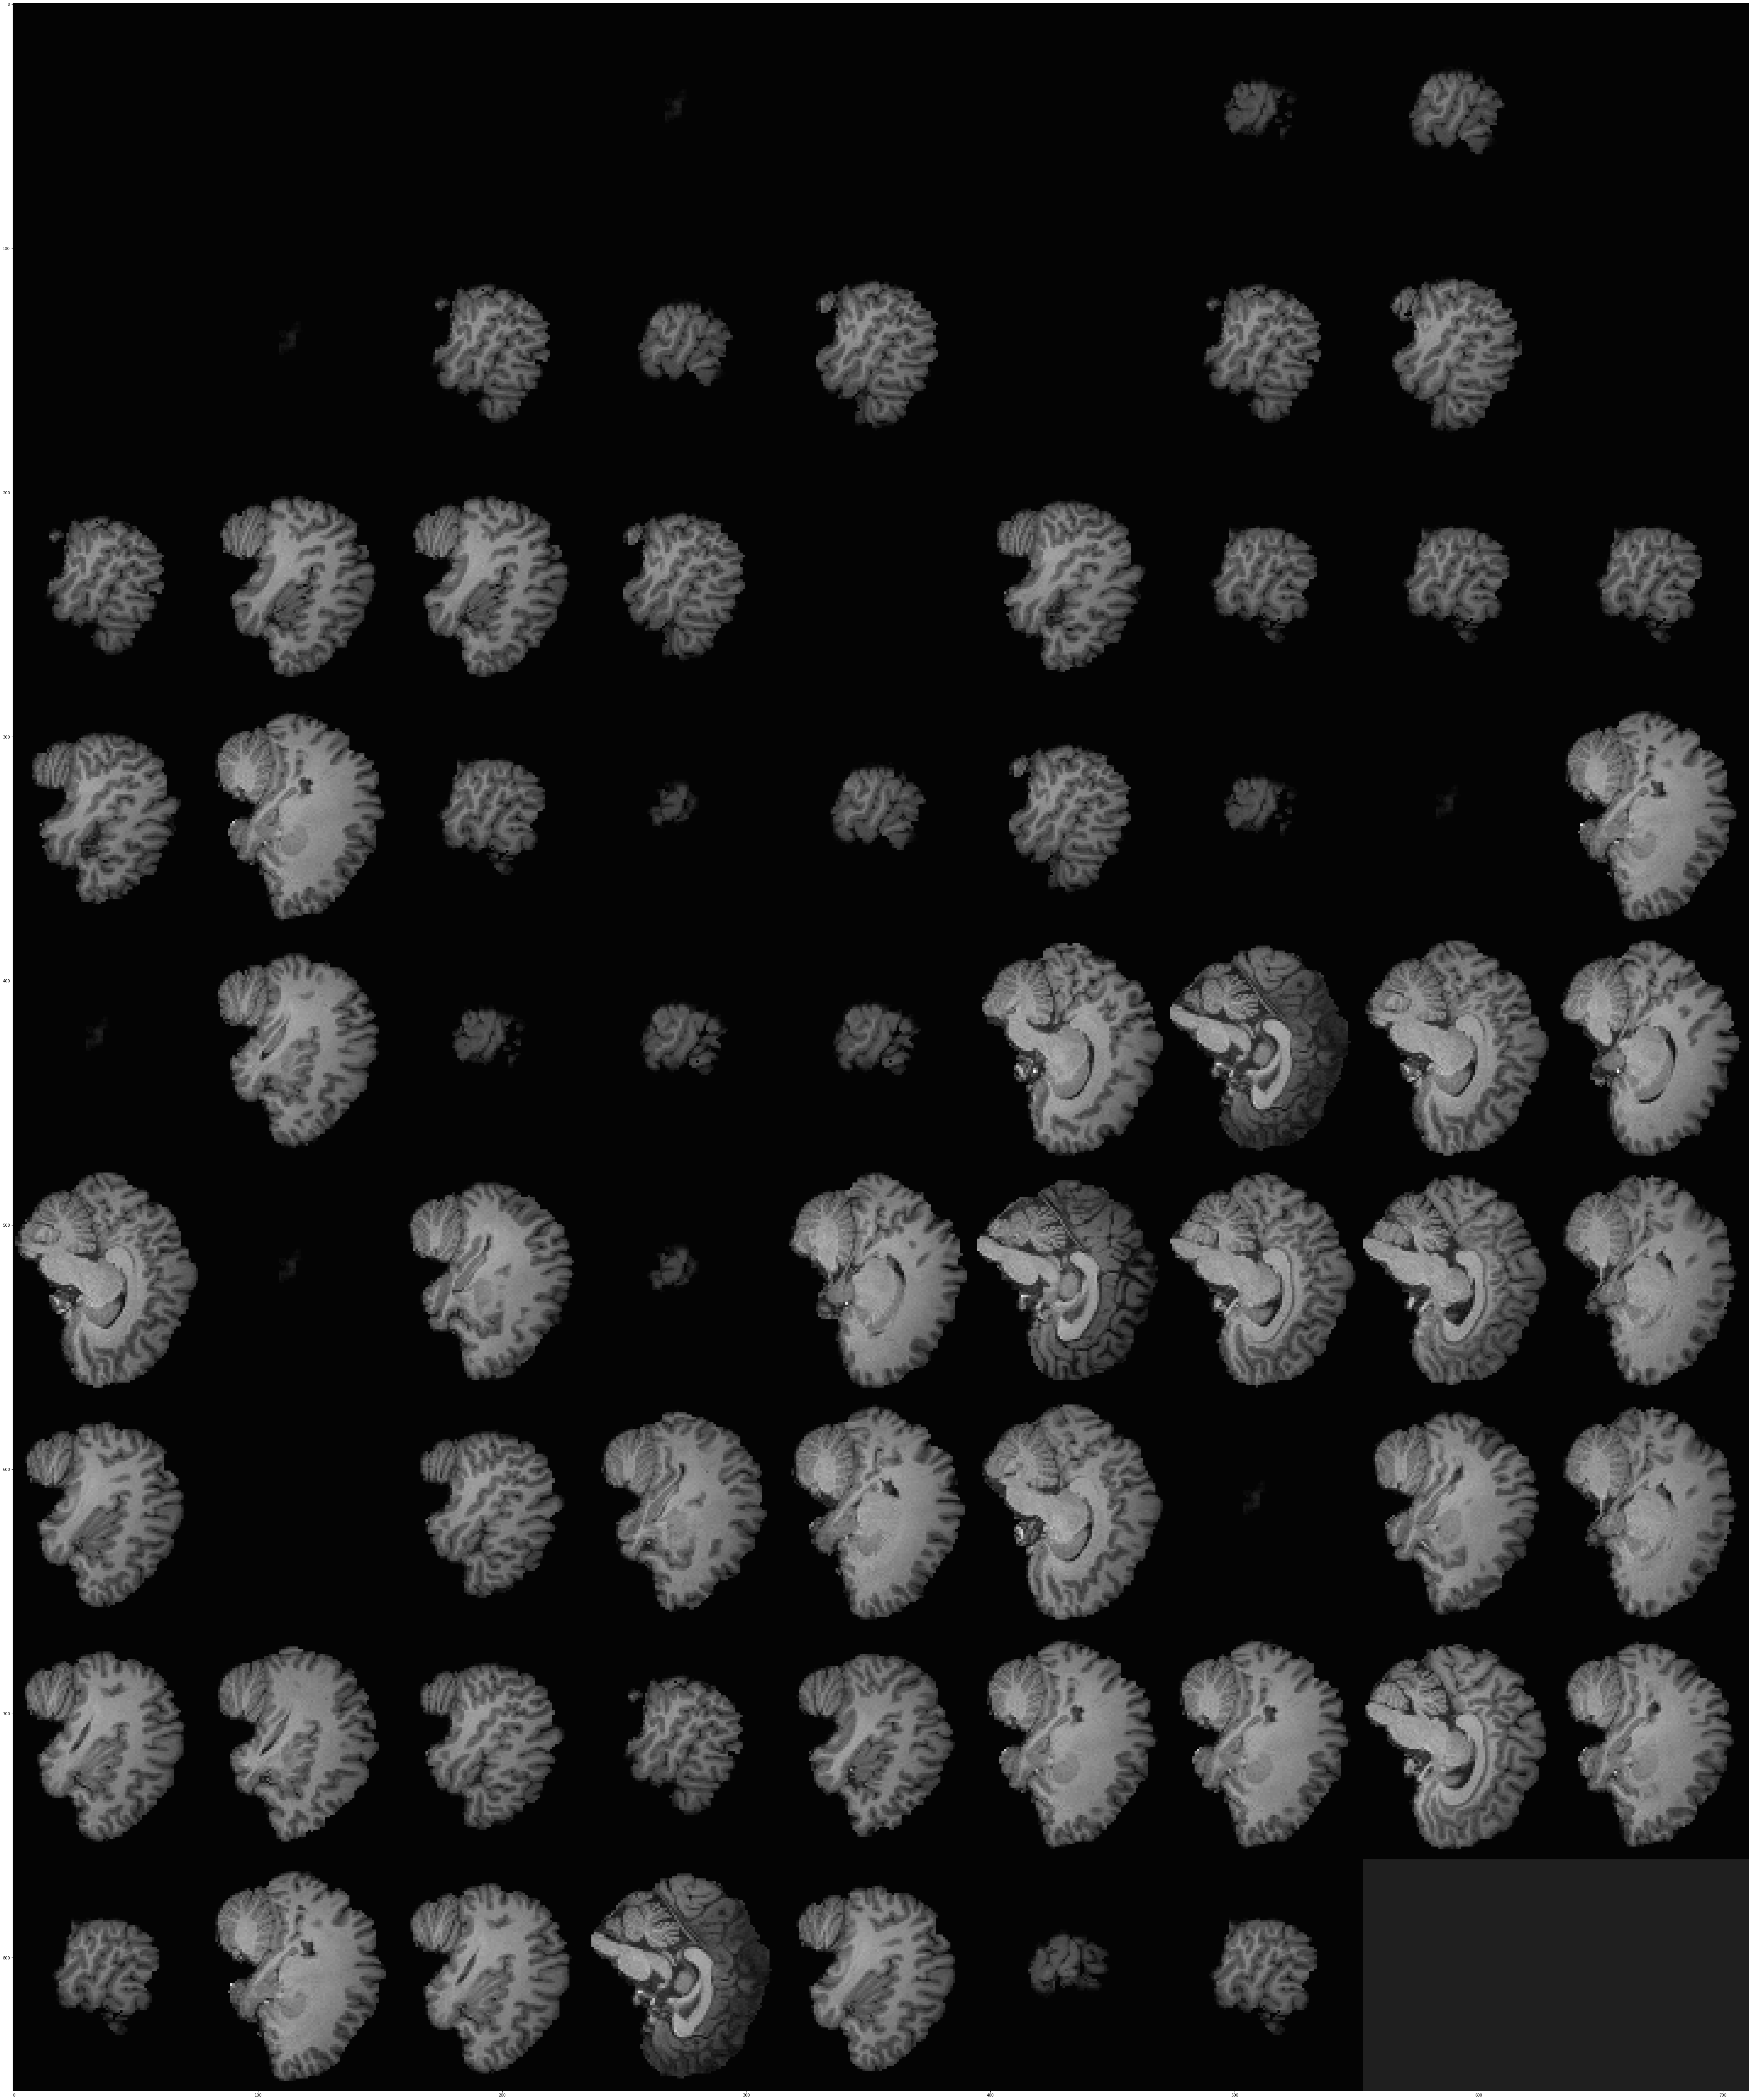

In [8]:
# EDA
from skimage.util import montage as montage2d
fig, showImg = plt.subplots(1, 1, figsize = (100, 100))
showImg.imshow(montage2d(imagesTest), cmap ='gray')

100%|██████████| 674/674 [00:12<00:00, 52.95it/s]


Text(0.5, 1.0, 'Image')

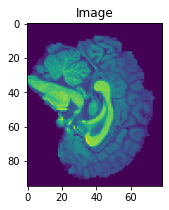

In [9]:
from tqdm import tqdm

showImgArr = []

for i in tqdm(range(brainMRIData.shape[0])):
    try:
        import nibabel as nib
    except:
        raise ImportError('Install NIBABEL')

    t_image=nib.load(brainMRIImages[0]).get_fdata()
     
     
    t_image= t_image/255
    showImgArr.append(t_image)
test = np.array(showImgArr)

%matplotlib inline
 
test_image=nib.load('/content/drive/MyDrive/brains/wCF_023_MRI_sMRI_CF_023_brain.nii.gz')
t_image=test_image.get_fdata()
(fig, ax1) = plt.subplots( figsize = (6, 3))
ax1.imshow(t_image[t_image.shape[2]//2])
ax1.set_title('Image')

Text(0.5, 1.0, 'Image')

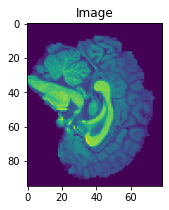

In [10]:
%matplotlib inline
 
test_image=nib.load('/content/drive/MyDrive/brains/wCF_023_MRI_sMRI_CF_023_brain.nii.gz')
t_image=test_image.get_fdata()
(fig, ax1) = plt.subplots( figsize = (6, 3))
ax1.imshow(t_image[t_image.shape[2]//2])
ax1.set_title('Image')

In [11]:
import skimage.transform as skTrans
# array
showImgArr = []
# import image
for i in tqdm(range(brainMRIData.shape[0])):
    try:
        import nibabel as nib
    except:
        raise ImportError('Install NIBABEL')

    imagesTest=nib.load(brainMRIImages[10])
    imagesTest=imagesTest.get_fdata()
    # suffle images
    random.shuffle(imagesTest)
    
    FigT= imagesTest/255
    # append image
    showImgArr.append(FigT)

# set array value
X = np.array(showImgArr)

100%|██████████| 674/674 [00:19<00:00, 34.33it/s]


In [12]:
X.shape

(674, 79, 95, 79)

In [13]:
# find y value
#y = np.array(brainMRIData.drop(['ID_CF', 'First Episodes (FEP) / Healthy Control (HC)'],axis=1))
y = np.array(brainMRIData['Class'])
y.shape

(674,)

In [14]:
# split data

# xTrainValue, xTestValue, yTrainValue, yTestValue = train_test_split(X, y, random_state=32, test_size=0.2)
# yTrainValue

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)
# y_train

#cnn

In [15]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [16]:
#CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(input_shape=(79, 95, 79),filters=64,kernel_size=(3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [ ]:
model.summary()

testing

In [18]:
# xTrainValue, xTestValue, yTrainValue, yTestValue = train_test_split(X, y, random_state=32, test_size=0.2)
# yTrainValue

x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=69)


In [19]:
# model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), 
#                  optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
history=model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


# hist = model.fit_generator(steps_per_epoch=10,generator=x_train, validation_data=(x_test, y_test), validation_steps=10,epochs=100)

# history = model.fit(x_train, y_train, epochs=10, batch_size=40, verbose=1,validation_data=(x_test, y_test))


Epoch 1/10
17/17 [==============================] - 76s 4s/step - loss: 0.6394 - accuracy: 0.6642 - val_loss: 0.6206 - val_accuracy: 0.6889
Epoch 2/10
17/17 [==============================] - 76s 4s/step - loss: 0.6389 - accuracy: 0.6642 - val_loss: 0.6222 - val_accuracy: 0.6889
Epoch 3/10
17/17 [==============================] - 76s 4s/step - loss: 0.6391 - accuracy: 0.6642 - val_loss: 0.6215 - val_accuracy: 0.6889
Epoch 4/10
17/17 [==============================] - 76s 4s/step - loss: 0.6400 - accuracy: 0.6642 - val_loss: 0.6250 - val_accuracy: 0.6889
Epoch 5/10
17/17 [==============================] - 76s 4s/step - loss: 0.6394 - accuracy: 0.6642 - val_loss: 0.6217 - val_accuracy: 0.6889
Epoch 6/10
17/17 [==============================] - 76s 5s/step - loss: 0.6402 - accuracy: 0.6642 - val_loss: 0.6203 - val_accuracy: 0.6889
Epoch 7/10
17/17 [==============================] - 76s 5s/step - loss: 0.6388 - accuracy: 0.6642 - val_loss: 0.6222 - val_accuracy: 0.6889
Epoch 8/10
17/17 [==

original

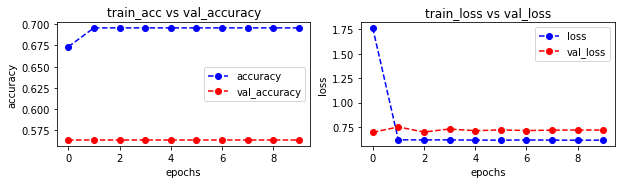

In [39]:
# plot the accuracy and loss
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    # find accuracy
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    # find validation accuracy
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    # set title
    plt.title("train_acc vs val_accuracy")
    # set labels
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    # set legend
    plt.legend()

    # Plot loss 
    plt.subplot(222)
    # find loss value
    plt.plot(history.history['loss'],'bo--', label = "loss")
    # find validation loss value
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    # set labels and legend
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
# plot accuracy and loss
plot_accuracy_loss(history)

In [23]:
# CNNmodel evaluation
lossTest = model.evaluate(xTestValue, yTestValue)


5/5 [==============================] - 4s 796ms/step - loss: 0.7176 - accuracy: 0.5630
